# What do the dimensions of the capsules represent?

### This block only prepares everything (import modules, load the data, define the data flow graph)

In [5]:
import numpy as np
import tensorflow as tf
import os
import struct
import matplotlib.pyplot as plt
from layers.capslayer import CapsLayer
from layers.convcapslayer import ConvCapsLayer
from layers.convlayer import ConvLayer
from layers.denselayer import DenseLayer
from wrappers.mnisthelper import MNIST

# Loading the data.
mnist_data = MNIST('./mnist_data/')

# Define the functions needed for the data flow graph
def mask_and_flatten_digit_caps(digit_caps, labels):
    """Mask out and flat the digit caps.

    All but the 16 values of the capsule corresponding to the correct label
    are set to 0. Then the digit caps are reshaped from [batch_size, 10, 16] to
    [batch_size, 10*16].
    """
    # Create a tensor in the same shape as the digit caps with ones at the
    # entries that are corresponding to the entries for the correct label
    # and zero everywhere else.
    labels = tf.one_hot(labels, depth=10)
    labels = tf.expand_dims(labels, axis=-1)
    labels = tf.tile(labels, [1,1,16])
    # Mask out the digit caps.
    masked_digit_caps = digit_caps * labels
    # Read out the batch size from the labels.
    batch_size = tf.shape(labels)[0]
    # Flat the digit caps.
    masked_and_flat = tf.reshape(masked_digit_caps, shape=[batch_size,10*16])
    return masked_and_flat

def calculate_loss_accuracy(digit_caps, labels):
    """Calculate the loss and the accuracy.

    The loss implements the loss from the paper. For more information check our
    report.
    Accuracy is computed by taking the digit with "longest" capsule, meaning the
    digit where the model is the most sure, that it is in the image, as the
    prediction of the network.
    """
    # Compute the length (euclidean norm) of the digit capsules.
    length_digit_caps = tf.norm(digit_caps, axis = 2)
    labels_one_hot = tf.one_hot(labels, depth=10)
    # Compute the false negative part of the loss.
    plus_loss =  labels_one_hot * tf.nn.relu(0.9 - length_digit_caps)
    # Compute the fals positive part of the loss.
    minus_loss = 0.5 * (1 - labels_one_hot) * tf.nn.relu(length_digit_caps - 0.1)
    # Compute the loss from those two parts
    loss = tf.reduce_sum(plus_loss + minus_loss, axis=-1)
    loss = tf.reduce_mean(loss)
    # Compute accuracy by comparing indices of longest capusle to the labels.
    correct_prediction = tf.equal(tf.argmax(length_digit_caps, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return loss, accuracy

def calculate_reconstruction_loss(reconstructions, images):
    """Calculate the loss of the reconstruction."""
    # As the reconstructor has a sigmoid read out layer scale pixel intensties
    # of the images down to [0,1].
    images = images/255.0
    # Compute the sum squared error between reconstruction and original image.
    squared_error = tf.squared_difference(reconstructions, images)
    sum_squared_error = tf.reduce_sum(squared_error, axis=-1)
    # Scale down the reconstruction loss to let it not dominate the loss.
    reconstruction_loss = 0.0005 * tf.reduce_mean(sum_squared_error)
    return reconstruction_loss
    

# Define the daata flow graph. 
# Reset the graph.
tf.reset_default_graph()
# Define the placeholders.
image_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28])
label_placeholder = tf.placeholder(dtype=tf.int64, shape=[None])
# Read out the batch size from the placeholders.
batch_size = tf.shape(image_placeholder)[0]

# Convolutional layer.
with tf.variable_scope('ReLU_Conv1'):
    # Add fourth dimension (number of channels) to the images, because it is
    # needed for convolution.
    image_reshaped = tf.expand_dims(image_placeholder, axis=-1)
    convolution = ConvLayer(
                    kernel_size = 9,
                    stride = 1,
                    padding = 'VALID',
                    channels = 256,
                    activation_function = 'ReLU'
                  )(image_reshaped)

# Primary Caps layer. Does another convolution and cuts it into capsules.
with tf.variable_scope('Primary_Caps'):
    primary_caps = ConvCapsLayer(
                        kernel_size = 9,
                        stride = 2,
                        padding = 'VALID',
                        dimension = 8,
                        channels = 32,
                    )(convolution)

# Digit Caps layer. Basically the readout layer, that decides if the network
# recognized a certain digit or not.
with tf.variable_scope('Digit_Caps'):
    digit_caps = CapsLayer(
                        count2 = 10,
                        dim2 = 16,
                        rout_iter = 3
                 )(primary_caps)

# Calculate the loss and the accuracy of the read out.
with tf.variable_scope('Loss'):
    loss, accuracy = calculate_loss_accuracy(digit_caps, label_placeholder)

# Reconstructor that reconstructs the image from the representation of the
# digit capsules. Consist of three dense layers.
# Initialize a placeholder for the digit capsules to feed in the perturbed versions.
digit_caps_placeholder = tf.placeholder(dtype=tf.float32, shape=[10, 16])
with tf.variable_scope('Dense1'):
    # Mask out (set to zero) all but the correct digit capsule and flatten
    # the tensor for the dense layer.
    digit_caps_flat = mask_and_flatten_digit_caps(digit_caps_placeholder, label_placeholder)
    dense_1 = DenseLayer(
                    n_out = 512,
                    activation_function = 'ReLU'
              )(digit_caps_flat)

with tf.variable_scope('Dense2'):
    dense_2 = DenseLayer(
                    n_out = 1024,
                    activation_function = 'ReLU'
              )(dense_1)

with tf.variable_scope('Dense3'):
    dense_3 = DenseLayer(
                    n_out = 28*28,
                    activation_function = 'Sigmoid'
              )(dense_2)
    # Reshape the output of this layer to same shape as the original image,
    # to obtain the reconstruction.
    reconstructions = tf.reshape(dense_3, shape=[batch_size, 28, 28])

# Calculate the loss of the reconstruction.
with tf.variable_scope('Reconstruction_Loss'):
    reconstruction_loss = calculate_reconstruction_loss(reconstructions, image_placeholder)

# Set AdamOptimizer with default values (as described in the paper) as
# optimizer. It minimizes the sum of the loss and the reconstruction loss.
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    total_loss = loss + reconstruction_loss
    training_step = optimizer.minimize(total_loss)

/home/luke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
keep_dims is deprecated, use keepdims instead


### We can now have a look at, how the reconstruction of an capsule changes for slight adjustments (adding or substracting a small delta) in a certain dimension

In [6]:
def perturb(capsules, label):
    """Perturb the different dimension of a capsule.
    
    Tweak each dimension with 0.05 intervals between -0.25 and 0.25.
    """
    
    # Get the array out of two unnecessary lists.
    capsules = capsules[0][0]
    # Initialize list to save the peturbed capsules.
    perturbed_caps = []
    # For every dimension.
    for dim in range(16):
        # For eleven deltas in [-0.25, 0.25].
        for delta in np.linspace(-0.25, 0.25, 11):
            # Copy the capsules to not change the orginal ones.
            d = np.copy(capsules)
            # Add delta to the entry of the current dimension.
            d[label,dim] += delta
            # Save the perturbed capsules in list.
            perturbed_caps.append(d)
     # Split it up in to one list for each dimension.
    perturbed_caps = [perturbed_caps[i:i+11] for i in range(0, len(perturbed_caps), 11)]     
    return perturbed_caps

In [14]:
def random_digit_all_dimensions():
    """Plot reconstructions for perturbations of all dimension for a random digit.
    
    The digit is randomly chosen from the training set.
    This function is to explore the reconstructions and "meanings" of the dimensions
    on a large scale.
    """
    # Initialize TensorFlow "Saver" to restore the weights.
    saver = tf.train.Saver()
    # Session to look at the reconstructions.
    with tf.Session() as sess:
        # Restore the weights from model.ckpt.
        saver.restore(sess, "./tmp/model.ckpt")

        # Get random image sample for which to look at the perturbed versions.
        generator = mnist_data.get_training_batch(1)
        for x, y in generator:
            image_sample = x
            label_sample = y
            break
        # Compute the capsules for that image.
        capsules = sess.run([digit_caps],feed_dict = {
                                            image_placeholder: image_sample,
                                            label_placeholder: label_sample
                                          }
                    )
        # Compute the perturbed versions of this capsule.
        perturbed_capsules = perturb(capsules, label_sample)


        # For the lists corresponding to all perturbings for one dimension.
        for j, dimension_list in enumerate(perturbed_capsules):
            # Print the current dimension.
            print('Dimension {}'.format(j+1))
            # Initialize a figure.
            fig = plt.figure(figsize = (15,10))
            # For all capsules corresponding to a pertubing with delta in the current dimension.
            for i, delta_capsule in enumerate(dimension_list):
                # Obtain the reconstructions from the graph.
                _reconstructions = sess.run([reconstructions],feed_dict = {
                                                                digit_caps_placeholder: delta_capsule,
                                                                image_placeholder: image_sample,
                                                                label_placeholder: label_sample
                                                              }
                                   )
                # Add the reconstruction as an suplot to the figure.
                fig.add_subplot(1,11,i+1)
                plt.imshow(_reconstructions[0][0], cmap='gray')
                plt.axis('off')
            # Show the plot.
            plt.show()
            
def specific_digit_specific_dimension(digit, dimension):
    """Plot reconstructions for perturbations of certain dimension for a certain digits.
    
    The sample is randomly chosen from the training set, but is the specified digit.
    This function is to validate assumptions above the "meanin" of a certain dimension
    of a certain capsule.
    """
    # Initialize TensorFlow "Saver" to restore the weights.
    saver = tf.train.Saver()
    # Session to look at the reconstructions.
    with tf.Session() as sess:
        # Restore the weights from model.ckpt.
        saver.restore(sess, "./tmp/model.ckpt")

        # Get random image sample for which to look at the perturbed versions.
        generator = mnist_data.get_training_batch(1)
        for x, y in generator:
            if y[0] == digit:
                image_sample = x
                label_sample = y
                break
        # Compute the capsules for that image.
        capsules = sess.run([digit_caps],feed_dict = {
                                            image_placeholder: image_sample,
                                            label_placeholder: label_sample
                                          }
                    )
        # Compute the perturbed versions of this capsule.
        perturbed_capsules = perturb(capsules, label_sample)
        # Extract only the specified dimension.
        perturbed_capsules = perturbed_capsules[dimension-1]

        # Print the specified digit and dimension.
        print('Digit {}, Dimension {}'.format(digit, dimension))
        # Initialize a figure.
        fig = plt.figure(figsize = (15,10))
        # For all capsules corresponding to a pertubing with delta in the current dimension.
        for i, delta_capsule in enumerate(perturbed_capsules):
            # Obtain the reconstructions from the graph.
            _reconstructions = sess.run([reconstructions],feed_dict = {
                                                            digit_caps_placeholder: delta_capsule,
                                                            image_placeholder: image_sample,
                                                            label_placeholder: label_sample
                                                          }
                               )
            # Add the reconstruction as an suplot to the figure.
            fig.add_subplot(1,11,i+1)
            plt.imshow(_reconstructions[0][0], cmap='gray')
            plt.axis('off')
        # Show the plot.
        plt.show()

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Digit 8, Dimension 3


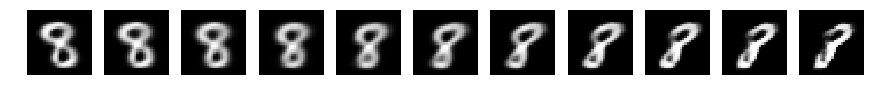

In [15]:
specific_digit_specific_dimension(8,3)